# Rent Prices & Nearby Venues Data Analysis of Munich


In [1109]:
#Required Libraries for the project
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.cluster import KMeans #library for clustering

## PART 1/ DATA SCRAPING and CLEANING

### DATASET 1 (df) - Postal Code, Latitude and Longitude

In [1110]:
#Get the data from geonames website into Pandas DF
dfs = pd.read_html('https://www.geonames.org/postal-codes/DE/BY/bayern.html')
df=dfs[2] # index 2 to import only first table from the list
df.head()

,Unnamed: 0,Place,Code,Country,Admin1,Admin2,Admin3,Admin4
0,1.0000000000,MÃ¼nchen,80331,Germany,Bayern,Upper Bavaria,Kreisfreie Stadt MÃ¼nchen,"MÃ¼nchen, Landeshauptstadt"
1,nan,48.135/11.571,48.135/11.571,48.135/11.571,48.135/11.571,48.135/11.571,48.135/11.571,48.135/11.571
2,2.0000000000,MÃ¼nchen,80333,Germany,Bayern,Upper Bavaria,Kreisfreie Stadt MÃ¼nchen,"MÃ¼nchen, Landeshauptstadt"
3,nan,48.145/11.567,48.145/11.567,48.145/11.567,48.145/11.567,48.145/11.567,48.145/11.567,48.145/11.567
4,3.0000000000,MÃ¼nchen,80335,Germany,Bayern,Upper Bavaria,Kreisfreie Stadt MÃ¼nchen,"MÃ¼nchen, Landeshauptstadt"


In [1111]:
#group even and odd rows
df = df.groupby(df.index // 2).agg(lambda x: x.dropna().astype(str).str.cat(sep=' '))

#drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'Country', 'Admin1', 'Admin2', 'Admin3', 'Admin4'])

# replace the matching strings 
df = df.replace(to_replace ='MÃ¼nchen', value = 'Munich', regex = True)
df = df.replace(to_replace ='/', value = ' ', regex = True)

# extract coordinates and create new column:'coordinates'
temp_df1 = df["Place"].str.split(" ", n = 2, expand = True) 
temp_df2 = df["Code"].str.split(" ", n = 2, expand = True)
df["City"]= temp_df1[0] 
df["Latitude"]= temp_df1[1]
df["Longitude"]= temp_df1[2]
df["Postal Code"]= temp_df2[0] 
df = df[["City","Postal Code","Latitude","Longitude"]]

#keep only City = Munich
df = df[df.City == 'Munich']
df= df[['City','Postal Code','Latitude','Longitude']]
df.head()

,City,Postal Code,Latitude,Longitude
0,Munich,80331,48.135,11.571
1,Munich,80333,48.145,11.567
2,Munich,80335,48.143,11.555
3,Munich,80336,48.135,11.559
4,Munich,80337,48.122,11.545


### DATASET 2 (df2) - Average price Monthly Rents for every Postal Code/Districts

In [1112]:
#Download CSV file from github repository: Average_apart_rent_Munich.csv
url_temp_1='https://raw.githubusercontent.com/matborg83/Coursera_Capstone_Munich/main/Average_apart_rent_Munich.csv'
temp_1 = pd.read_csv(url_temp_1)
temp_1 = temp_1.replace(to_replace ='Muchen', value = 'Munich', regex = True) #typo error in CSV file

# Combine 'Neuhausen' and 'Nymphenburg' and calculate the mean price (to match value 'Nymphenburg' in temp_2)
temp_1 = temp_1.replace(to_replace ='Neuhausen', value = 'Nymphenburg', regex = True)
temp_1 = temp_1.groupby(['District'],as_index=False).agg({'Monthly rent (EUR/Sq meter)': 'mean'})
temp_1= temp_1.replace(to_replace ='Nymphenburg', value = 'Neuhausen-Nymphenburg', regex = True) 
temp_1 = temp_1.round({'Monthly rent (EUR/Sq meter)': 2})

temp_1

,District,Monthly rent (EUR/Sq meter)
0,Altstadt-Lehel,26.5700000000
1,Au-Haidhausen,22.9200000000
2,Bogenhausen,21.1700000000
3,Harlaching,20.8900000000
4,Ludwigsvorstadt-Isarvorstadt,24.4900000000
5,Maxvorstadt,23.4500000000
6,Milbertshofen-Am Hart,22.7200000000
7,Munich,20.3700000000
8,Neuhausen-Nymphenburg,19.9900000000
9,Pasing,21.4600000000


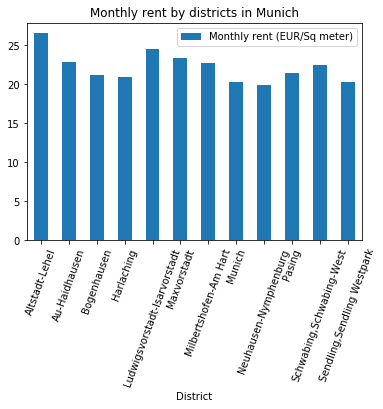

In [1115]:
#Barchart Monthly rent by districts
temp_1.plot.bar(x="District", y="Monthly rent (EUR/Sq meter)", rot=70, title="Monthly rent by districts in Munich ()")

In [1083]:
#Download CSV file from github repository: Postal_Code_Munich(3).csv
url_temp_2='https://raw.githubusercontent.com/matborg83/Coursera_Capstone_Munich/main/Postal_Code_Munich(3).csv'
temp_2= pd.read_csv(url_temp_2)

# Normalizing district values to match dataset temp_1
temp_2.loc[85:100,'district'] = 'Schwabing,Schwabing-West'
temp_2 = temp_2.replace(to_replace ='Untergiesing-Harlaching', value = 'Harlaching', regex = True)
temp_2.loc[103:114,'district'] = 'Sendling,Sendling Westpark'
temp_2 = temp_2.replace(to_replace ='Pasing-Obermenzing', value = 'Pasing', regex = True)

temp_2.head()

,district,Postal Code
0,Allach-Untermenzing,80995
1,Allach-Untermenzing,80997
2,Allach-Untermenzing,80999
3,Allach-Untermenzing,81247
4,Allach-Untermenzing,81249


In [1084]:
df2 = pd.merge(left=temp_1, right=temp_2, left_on='District', right_on='district')
df2= df2[['Postal Code','District','Monthly rent (EUR/Sq meter)']]
df2.head()

,Postal Code,District,Monthly rent (EUR/Sq meter)
0,80331,Altstadt-Lehel,26.5700000000
1,80333,Altstadt-Lehel,26.5700000000
2,80335,Altstadt-Lehel,26.5700000000
3,80336,Altstadt-Lehel,26.5700000000
4,80469,Altstadt-Lehel,26.5700000000


### DATASET 3 (df3) - All above combined

In [1085]:
df["Postal Code"] = df["Postal Code"].astype(str).astype(int)
df3 = pd.merge(left=df, right=df2, left_on='Postal Code', right_on='Postal Code')
df3= df3[['Postal Code','District','Monthly rent (EUR/Sq meter)','Latitude','Longitude']]

df3.head()

,Postal Code,District,Monthly rent (EUR/Sq meter),Latitude,Longitude
0,80331,Altstadt-Lehel,26.5700000000,48.135,11.571
1,80333,Altstadt-Lehel,26.5700000000,48.145,11.567
2,80333,Maxvorstadt,23.4500000000,48.145,11.567
3,80335,Altstadt-Lehel,26.5700000000,48.143,11.555
4,80335,Ludwigsvorstadt-Isarvorstadt,24.4900000000,48.143,11.555


In [1086]:
# Concat Postal Code to create combined Districts with the associated average monthly rent price
temp_3 = df3.sort_values(['Postal Code','District']).groupby('Postal Code', sort=False).District.apply('//'.join).reset_index(name='Combined Districts') 
temp_4= df3.groupby(['Postal Code'],as_index=False).agg({'Monthly rent (EUR/Sq meter)': 'mean'})
temp_5 = pd.merge(left=temp_3, right=temp_4, left_on='Postal Code', right_on='Postal Code')

df3 = pd.merge(left=temp_5, right=df, left_on='Postal Code', right_on='Postal Code')
df3 = df3.drop(['City'], axis=1)
df3

,Postal Code,Combined Districts,Monthly rent (EUR/Sq meter),Latitude,Longitude
0,80331,Altstadt-Lehel,26.5700000000,48.135,11.571
1,80333,Altstadt-Lehel//Maxvorstadt,25.0100000000,48.145,11.567
2,80335,Altstadt-Lehel//Ludwigsvorstadt-Isarvorstadt//...,24.8366666667,48.143,11.555
3,80336,Altstadt-Lehel//Ludwigsvorstadt-Isarvorstadt//...,23.7733333333,48.135,11.559
4,80337,"Ludwigsvorstadt-Isarvorstadt//Sendling,Sendlin...",22.3750000000,48.122,11.545
5,80469,Altstadt-Lehel//Ludwigsvorstadt-Isarvorstadt//...,23.7733333333,48.13,11.573
6,80538,"Altstadt-Lehel//Schwabing,Schwabing-West",24.5150000000,48.14,11.588
7,80539,Altstadt-Lehel//Maxvorstadt,25.0100000000,48.15,11.583
8,80634,Neuhausen-Nymphenburg,19.9900000000,48.149,11.533
9,80636,Maxvorstadt//Neuhausen-Nymphenburg,21.7200000000,48.156,11.541


### Dataset 4 (Postal_Code_venues_sorted) - 10 main venues for each postal code

In [1087]:
# Define Foursquare Credentials and Version
CLIENT_ID = '3WTP1JKGYST5OV1CAUS3KVOB2I2PGLPTC054P2IF5NWZJYRO' # your Foursquare ID
CLIENT_SECRET = 'HUWVSOQ1NWJEU4TCJ3AMODP0X2KMXHL2UKHSIGUBFR315N2V' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3WTP1JKGYST5OV1CAUS3KVOB2I2PGLPTC054P2IF5NWZJYRO
CLIENT_SECRET:HUWVSOQ1NWJEU4TCJ3AMODP0X2KMXHL2UKHSIGUBFR315N2V


In [1088]:
#get venues that are in each Postal Code within a radius of 500 meters.

def getNearbyVenues(Postal_Code, latitude, longitude, radius=500):
    
    venues_list=[]
    for Postal, lat, lng in zip(Postal_Code, latitude, longitude):
        print(Postal)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            Postal, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Postal_code_venues = getNearbyVenues(Postal_Code=df3['Postal Code'],
                                   latitude=df3['Latitude'],
                                   longitude=df3['Longitude']
                                  )

80331
80333
80335
80336
80337
80469
80538
80539
80634
80636
80637
80638
80639
80686
80687
80689
80796
80797
80798
80799
80801
80802
80803
80804
80805
80807
80809
80937
80939
81241
81243
81245
81247
81369
81371
81373
81377
81379
81541
81543
81545
81547
81667
81669
81671
81675
81677
81679
81925
81927
81929


In [1089]:
print(Postal_code_venues.shape)
Postal_code_venues.head() #remove .head)() to see all data


(1674, 7)


,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,80331,48.135,11.571,Asamkirche (St. Johann Nepomuk),48.1350534503,11.5697462772,Church
1,80331,48.135,11.571,Japanische Feinkost Mikado (美門日本食料品店),48.1361261400,11.5687318300,Gourmet Shop
2,80331,48.135,11.571,The High,48.1331010263,11.5729389662,Cocktail Bar
3,80331,48.135,11.571,Ringlers,48.1340970000,11.5683020000,Sandwich Place
4,80331,48.135,11.571,TeeGschwendner,48.1353980000,11.5694550000,Tea Room


In [1090]:
# Venues categories encountered in each Postal Code
# one hot encoding
munich_onehot = pd.get_dummies(Postal_code_venues[['Venue Category']], prefix="", prefix_sep="")

# add Postal Code column back to dataframe
munich_onehot['Postal Code'] = Postal_code_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]

munich_onehot.shape
munich_onehot.head()

,Postal Code,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Boarding House,Bookstore,Bosnian Restaurant,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Canal,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Historic Site,History Museum,Hostel,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Lake,Laundromat,Laundry Service,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Manti Place,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music School,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Radio Station,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Sandwich Place,Sausage Shop,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,80331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,80331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,80331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [1091]:
#Groups the above rows by Postal Code and by taking the mean of the frequency of occurrence of each category
Postal_Code_grouped = munich_onehot.groupby('Postal Code').mean().reset_index()
Postal_Code_grouped.head()

,Postal Code,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Boarding House,Bookstore,Bosnian Restaurant,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Canal,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Historic Site,History Museum,Hostel,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Lake,Laundromat,Laundry Service,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Manti Place,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music School,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Radio Station,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Sandwich Place,Sausage Shop,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,80331,0.0200000000,0.0000000000,0.0000000000,0.0000000000,0.0100000000,0.0100000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0200000000,0.0400000000,0.0000000000,0.0000000000,0.0000000000,0.0100000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0200000000,0.0000000000,0.0000000000,0.0200000000,0.0000000000,0.0000000000,0.0000000000,0.0100000000,0.0100000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0700000000,0.0000000000,0.0000000000,0.0000000000,0.0100000000,0.0000000000,0.0300000000,0.0000000000,0.0000000000,0.0300000000,0.0300000000,0.0400000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0300000000,0.0000000000,0.0000000000,0.0100000000,0.0000000000,0.0000000000,0.0000000000,0.0100000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0100000000,0

In [1092]:
# create the final dataframe and display the top 10 venues for each postal code
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Postal_Code_venues_sorted = pd.DataFrame(columns=columns)
Postal_Code_venues_sorted['Postal Code'] = Postal_Code_grouped['Postal Code']

for ind in np.arange(Postal_Code_grouped.shape[0]):
    Postal_Code_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Postal_Code_grouped.iloc[ind, :], num_top_venues)

Postal_Code_venues_sorted

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,80331,Café,German Restaurant,Hotel,Coffee Shop,Plaza,Bavarian Restaurant,Italian Restaurant,Cosmetics Shop,Cocktail Bar,Clothing Store
1,80333,Café,History Museum,Nightclub,Burger Joint,Restaurant,Plaza,Italian Restaurant,Art Museum,Asian Restaurant,Movie Theater
2,80335,Hotel,Bakery,Bar,Middle Eastern Restaurant,Coffee Shop,Drugstore,Post Office,Office,Italian Restaurant,Ice Cream Shop
3,80336,Hotel,Middle Eastern Restaurant,German Restaurant,Café,Camera Store,Asian Restaurant,Bakery,Mexican Restaurant,Nightclub,Indie Movie Theater
4,80337,Vietnamese Restaurant,Café,Italian Restaurant,Gastropub,Doner Restaurant,Supermarket,Food & Drink Shop,Bosnian Restaurant,Caucasian Restaurant,Restaurant
5,80469,Café,Bar,Vietnamese Restaurant,Asian Restaurant,Cocktail Bar,Pizza Place,Ice Cream Shop,Afghan Restaurant,Italian Restaurant,Gay Bar
6,80538,Italian Restaurant,German Restaurant,Hotel,Bar,Plaza,Pastry Shop,Art Museum,Burger Joint,Outdoor Sculpture,Snack Place
7,80539,Café,Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Thai Restaurant,Plaza,Doner Restaurant,Bagel Shop
8,80634,Hotel,Café,German Restaurant,Drugstore,Bakery,Indian Restaurant,Supermarket,Ice Cream Shop,Sushi Restaurant,Vietnamese Restaurant
9,80636,Bakery,German Restaurant,Indian Restaurant,Italian Restaurant,Hotel,Dessert Shop,Café,Restaurant,Ramen Restaurant,Organic Grocery


## PART 2/ CLUSTERING - MACHINE LEARNING

In [1093]:
# set number of clusters
kclusters = 5

#Drop postal code column before running the model.
munich_grouped_clustering = Postal_Code_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(munich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 2, 4, 4, 4, 2, 4, 2, 4, 4], dtype=int32)

In [1094]:
# add clustering labels
Postal_Code_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df4 = df3

# merge df4 with Postal_Code_venues_sorted to add latitude/longitude for each neighborhood
df4 = df4.join(Postal_Code_venues_sorted.set_index('Postal Code'), on='Postal Code')

df4

,Postal Code,Combined Districts,Monthly rent (EUR/Sq meter),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,80331,Altstadt-Lehel,26.5700000000,48.135,11.571,4,Café,German Restaurant,Hotel,Coffee Shop,Plaza,Bavarian Restaurant,Italian Restaurant,Cosmetics Shop,Cocktail Bar,Clothing Store
1,80333,Altstadt-Lehel//Maxvorstadt,25.0100000000,48.145,11.567,2,Café,History Museum,Nightclub,Burger Joint,Restaurant,Plaza,Italian Restaurant,Art Museum,Asian Restaurant,Movie Theater
2,80335,Altstadt-Lehel//Ludwigsvorstadt-Isarvorstadt//...,24.8366666667,48.143,11.555,4,Hotel,Bakery,Bar,Middle Eastern Restaurant,Coffee Shop,Drugstore,Post Office,Office,Italian Restaurant,Ice Cream Shop
3,80336,Altstadt-Lehel//Ludwigsvorstadt-Isarvorstadt//...,23.7733333333,48.135,11.559,4,Hotel,Middle Eastern Restaurant,German Restaurant,Café,Camera Store,Asian Restaurant,Bakery,Mexican Restaurant,Nightclub,Indie Movie Theater
4,80337,"Ludwigsvorstadt-Isarvorstadt//Sendling,Sendlin...",22.3750000000,48.122,11.545,4,Vietnamese Restaurant,Café,Italian Restaurant,Gastropub,Doner Restaurant,Supermarket,Food & Drink Shop,Bosnian Restaurant,Caucasian Restaurant,Restaurant
5,80469,Altstadt-Lehel//Ludwigsvorstadt-Isarvorstadt//...,23.7733333333,48.13,11.573,2,Café,Bar,Vietnamese Restaurant,Asian Restaurant,Cocktail Bar,Pizza Place,Ice Cream Shop,Afghan Restaurant,Italian Restaurant,Gay Bar
6,80538,"Altstadt-Lehel//Schwabing,Schwabing-West",24.5150000000,48.14,11.588,4,Italian Restaurant,German Restaurant,Hotel,Bar,Plaza,Pastry Shop,Art Museum,Burger Joint,Outdoor Sculpture,Snack Place
7,80539,Altstadt-Lehel//Maxvorstadt,25.0100000000,48.15,11.583,2,Café,Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Thai Restaurant,Plaza,Doner Restaurant,Bagel Shop
8,80634,Neuhausen-Nymphenburg,19.9900000000,48.149,11.533,4,Hotel,Café,German Restaurant,Drugstore,Bakery,Indian Restaurant,Supermarket,Ice Cream Shop,Sushi Restaurant,Vietnamese Restaurant
9,80636,Maxvorstadt//Neuhausen-Nymphenburg,21.7200000000,48.156,11.541,4,Bakery,German Restaurant,Indian Restaurant,Italian Restaurant,Hotel,Dessert Shop,Café,Restaurant,Ramen Restaurant,Organic Grocery


### PART 3/ DATA ANALYSING and VIZUALITATION

In [1095]:
# find the mean for monthly rents for each cluster in EUR
df_mean_price = pd.merge(left=df2, right=df4, left_on='Postal Code', right_on='Postal Code')
df_mean_price=df_mean_price[['Postal Code','Monthly rent (EUR/Sq meter)_x','Cluster Labels']]

cluster0 = df_mean_price[df_mean_price['Cluster Labels']==0]
mean_cluster0 = cluster0["Monthly rent (EUR/Sq meter)_x"].mean()

cluster1 = df_mean_price[df_mean_price['Cluster Labels']==1]
mean_cluster1 = cluster1["Monthly rent (EUR/Sq meter)_x"].mean()

cluster2 = df_mean_price[df_mean_price['Cluster Labels']==2]
mean_cluster2 = cluster2["Monthly rent (EUR/Sq meter)_x"].mean()

cluster3 = df_mean_price[df_mean_price['Cluster Labels']==3]
mean_cluster3 = cluster3["Monthly rent (EUR/Sq meter)_x"].mean()

cluster4 = df_mean_price[df_mean_price['Cluster Labels']==4]
mean_cluster4 = cluster5["Monthly rent (EUR/Sq meter)_x"].mean()

print('cluster 0 : ', mean_cluster0)
print('cluster 1 : ', mean_cluster1)
print('cluster 2 : ', mean_cluster2)
print('cluster 3 : ', mean_cluster3)
print('cluster 4 : ', mean_cluster4)

cluster 0 :  21.593333333333334
cluster 1 :  21.33230769230769
cluster 2 :  23.436111111111103
cluster 3 :  20.89
cluster 4 :  22.32636363636365


In [1096]:
# how many venues were returned in each clusters 
df_mean_number_venues = pd.merge(left=Postal_code_venues, right=df4, left_on='Postal Code', right_on='Postal Code')
df_mean_number_venues=df_mean_number_venues[['Cluster Labels','Venue']]
df_mean_number_venues.groupby('Cluster Labels').count()

,Venue
Cluster Labels,
0,18
1,129
2,629
3,1
4,897


### CLUSTER 0 : // Avg rent price: 21.59EUR (EUR/Sq meter) // 18 venues // Transportations, restaurants, fast foods and farmer markets

In [1097]:
df4.loc[df4['Cluster Labels'] == 0, df4.columns[[0] + list(range(5, df4.shape[1]))]]

,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,80937,0,Bus Stop,Mexican Restaurant,Metro Station,German Restaurant,Yoga Studio,Doner Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
41,81547,0,Bus Stop,Metro Station,Ice Cream Shop,Italian Restaurant,Taverna,German Restaurant,Doner Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant
50,81929,0,Bus Stop,Hotel,Business Service,Italian Restaurant,Cafeteria,Donut Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant


### CLUSTER 1: // Avg rent price: 21.33EUR(EUR/Sq meter) // 129 venues // Transportations, restaurants, supermarket, bakery, banks

In [1098]:
df4.loc[df4['Cluster Labels'] == 1, df4.columns[[0] + list(range(5, df4.shape[1]))]]

,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,80686,1,Supermarket,Bank,Bakery,Mobile Phone Shop,Doner Restaurant,Fried Chicken Joint,Restaurant,Caucasian Restaurant,Metro Station,Chinese Restaurant
15,80689,1,Supermarket,Bus Stop,Shop & Service,Drugstore,Bakery,Yoga Studio,Doner Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant
25,80807,1,Bus Stop,Supermarket,Gastropub,Italian Restaurant,Soccer Field,Drugstore,Food & Drink Shop,Shipping Store,Thai Restaurant,Bank
30,81243,1,Italian Restaurant,Soccer Field,Bakery,Bus Stop,Gym / Fitness Center,Rental Car Location,Yoga Studio,Donut Shop,Drugstore,Dumpling Restaurant
31,81245,1,Bakery,Hotel,Bistro,German Restaurant,Supermarket,Post Office,Soccer Field,Farmers Market,Falafel Restaurant,Event Space
32,81247,1,Bakery,Bus Stop,Hotel,Italian Restaurant,Supermarket,Drugstore,Tennis Court,Discount Store,German Restaurant,Hostel
36,81377,1,Bakery,Metro Station,Ice Cream Shop,Supermarket,Bus Stop,Chinese Restaurant,Donut Shop,Field,Fast Food Restaurant,Farmers Market
37,81379,1,Bus Stop,Supermarket,Rental Car Location,Bakery,Gym,Café,Bank,Greek Restaurant,Doner Restaurant,Construction & Landscaping
44,81671,1,Supermarket,Soccer Field,Plaza,German Restaurant,Indian Restaurant,Bakery,Eastern European Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
48,81925,1,Bus Stop,Theater,Bakery,Gas Station,Italian Restaurant,Bar,Falafel Restaurant,Event Space,Doner Restaurant,Farmers Market


### CLUSTER 2: // Avg rent price: 23.43EUR (EUR/Sq meter) // 624 venues // Cafes, bars and restaurants

In [1099]:
df4.loc[df4['Cluster Labels'] == 2, df4.columns[[0] + list(range(5, df4.shape[1]))]]

,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,80333,2,Café,History Museum,Nightclub,Burger Joint,Restaurant,Plaza,Italian Restaurant,Art Museum,Asian Restaurant,Movie Theater
5,80469,2,Café,Bar,Vietnamese Restaurant,Asian Restaurant,Cocktail Bar,Pizza Place,Ice Cream Shop,Afghan Restaurant,Italian Restaurant,Gay Bar
7,80539,2,Café,Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Thai Restaurant,Plaza,Doner Restaurant,Bagel Shop
16,80796,2,Café,Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Thai Restaurant,Plaza,Doner Restaurant,Bagel Shop
18,80798,2,Café,Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Thai Restaurant,Plaza,Doner Restaurant,Bagel Shop
19,80799,2,Café,Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Thai Restaurant,Plaza,Doner Restaurant,Bagel Shop
20,80801,2,Café,Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Thai Restaurant,Plaza,Doner Restaurant,Bagel Shop
22,80803,2,Café,Bar,Italian Restaurant,Ice Cream Shop,Restaurant,Sushi Restaurant,Thai Restaurant,Plaza,Doner Restaurant,Bagel Shop
42,81667,2,Italian Restaurant,Bar,Café,German Restaurant,Indian Restaurant,Plaza,Hotel,Ice Cream Shop,French Restaurant,Thai Restaurant


### CLUSTER 3: Outlier

In [1100]:
df4.loc[df4['Cluster Labels'] == 3, df4.columns[[0] + list(range(5, df4.shape[1]))]]

,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,81545,3,Coffee Shop,Yoga Studio,Discount Store,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant


### CLUSTER 4: // Avg rent price: 22.32EUR (EUR/Sq meter) // 898 venues // Multiple Social Venues, Accomodations

In [1101]:
df4.loc[df4['Cluster Labels'] == 4, df4.columns[[0] + list(range(5, df4.shape[1]))]]

,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,80331,4,Café,German Restaurant,Hotel,Coffee Shop,Plaza,Bavarian Restaurant,Italian Restaurant,Cosmetics Shop,Cocktail Bar,Clothing Store
2,80335,4,Hotel,Bakery,Bar,Middle Eastern Restaurant,Coffee Shop,Drugstore,Post Office,Office,Italian Restaurant,Ice Cream Shop
3,80336,4,Hotel,Middle Eastern Restaurant,German Restaurant,Café,Camera Store,Asian Restaurant,Bakery,Mexican Restaurant,Nightclub,Indie Movie Theater
4,80337,4,Vietnamese Restaurant,Café,Italian Restaurant,Gastropub,Doner Restaurant,Supermarket,Food & Drink Shop,Bosnian Restaurant,Caucasian Restaurant,Restaurant
6,80538,4,Italian Restaurant,German Restaurant,Hotel,Bar,Plaza,Pastry Shop,Art Museum,Burger Joint,Outdoor Sculpture,Snack Place
8,80634,4,Hotel,Café,German Restaurant,Drugstore,Bakery,Indian Restaurant,Supermarket,Ice Cream Shop,Sushi Restaurant,Vietnamese Restaurant
9,80636,4,Bakery,German Restaurant,Indian Restaurant,Italian Restaurant,Hotel,Dessert Shop,Café,Restaurant,Ramen Restaurant,Organic Grocery
10,80637,4,German Restaurant,Hotel,Tram Station,Supermarket,Taverna,Metro Station,Café,Italian Restaurant,Stadium,Light Rail Station
11,80638,4,Canal,Historic Site,Monument / Landmark,Park,Yoga Studio,Farmers Market,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
12,80639,4,Plaza,Greek Restaurant,Tram Station,Café,Light Rail Station,Beer Garden,Italian Restaurant,Supermarket,Pastry Shop,Park


In [1102]:
#Obtain Munich Latitude and Longitude with API Geolocator
address = 'Munich, DE'

geolocator = Nominatim(user_agent="TR_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Munich are {}, {}.'.format(latitude, longitude))

#modify df type for Lat and Long
df4['Latitude']= df4['Latitude'].astype(object).astype(float)
df4['Longitude']= df4['Longitude'].astype(object).astype(float)

#visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df4['Latitude'], df4['Longitude'], df4['Postal Code'], df4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

The geograpical coordinate of Munich are 48.1371079, 11.5753822.
